# Práctica 3: Implementación de un etiquetador POS para Otomí usando CRFs
- Implementar un etiquetador POS para el idioma otomí
    - Escenario retador de bajos recursos lingüísticos (low-resources)
    - Considerar que las feature functions **deben** cambiar (van acorde a la lengua)
    - Pueden usar bibliotecas conocidas para la implementación
- Comparar los resultados obtenidos con el CRF visto en clase
    - Reportar accuracy, precision, recall y F1-score
    - Mostrar un ejemplo de oracion etiquetada (Debe ser una oracion del conjunto de pruebas). Formato libre

#### Extra
- Hacer un análisis breve de los resultados
    - ¿Qué diferencias encuentran entre trabajar con textos en español y en Otomí?
    - ¿Se obtuvieron buenos o malos resultados? ¿Porqué?

In [1]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
from inspect import Attribute

## Preprocesamiento

### Lectura del corpus

In [2]:
path = './corpus_otomi'

In [3]:
import ast
encoding = 'utf-8'

try:
    with open(path, 'r', encoding=encoding) as f:
        contents = f.readlines()
        parsed_corpus = [ ast.literal_eval(x) for x in contents ]
except UnicodeDecodeError:
    print("Error: Unable to decode the file with the specified encoding.")
    
parsed_corpus[0]

[[['n', 'psd'], ['dó', '1.cpl'], ['phu̱di', 'stem'], 'v'],
 [['dó', '1.cpl'], ['pe̱phí', 'stem'], 'v'],
 [['bi', '3.cpl'], ['t', 'lig'], ["'u̱n", 'stem'], ['gí', '1.obj'], 'v'],
 [['bi', '3.cpl'], ['mähtratá', 'stem'], ['gí', '1.obj'], 'v'],
 [['ko', 'stem'], 'obl'],
 [['chíkóhté', 'stem'], 'obl']]

Cada elemento del corpus es una lista de palabras. Cada palabra está representada como una lista de tamaño *n* donde los primeros *n-1* elementos son pares *[ morfema, etiqueta]*, y el *n*-ésimo elemento es la etiqueta POS de la palabra. 

Ahora vamos a separar el corpus en las listas X e Y.

In [4]:
X = [ [word[:-1] for word in sent] for sent in parsed_corpus ]
Y = [ [word[-1] for word in sent] for sent in parsed_corpus ]

print("Y:", Y[0])
print("X:")
X[0]

Y: ['v', 'v', 'v', 'v', 'obl', 'obl']
X:


[[['n', 'psd'], ['dó', '1.cpl'], ['phu̱di', 'stem']],
 [['dó', '1.cpl'], ['pe̱phí', 'stem']],
 [['bi', '3.cpl'], ['t', 'lig'], ["'u̱n", 'stem'], ['gí', '1.obj']],
 [['bi', '3.cpl'], ['mähtratá', 'stem'], ['gí', '1.obj']],
 [['ko', 'stem']],
 [['chíkóhté', 'stem']]]

Revisamos todas las etiquetas en Y:

In [5]:
all_tags = []
for tags in Y:
    for tag in tags:
        if tag in all_tags:
            continue
        else:
            all_tags.append(tag)

print(all_tags)

['v', 'obl', 'det', 'cnj', 'neg', 'n', 'unkwn', 'it', 'dem', 'p.loc', 'prt', 'mexico', 'conj.adv', 'dec', 'tapanco', 'gen', 'lim', 'dim', 'conj', 'cord', 'aff', 'loc', 'san', 'andrés', 'cond', 'buena.vista', 'pascuala', 'nada.más', 'toluca', 'cnj.adv', 'zapata', 'calvario', 'bautisterio', 'adj', 'regular/v', 'chente', 'cristo', 'emilio', 'adv', 'juan', 'pato', 'luis', 'mextepec', 'chalma']


Notamos que hay varias que parecen estar incorrectas, así que las corregimos asignándoles el valor que creemos que deberían tener.

In [6]:
# Diccionario con las etiquetas que creemos que corresponden a las que tenemos
corrected_tags = { 
    'v': 'v',
    'obl': 'obl',
    'det': 'det',
    'cnj': 'cnj',
    'neg': 'neg',
    'n': 'n',
    'unkwn': 'unkwn',
    'it': 'unkwn',
    'dem': 'dem',
    'p.loc': 'p.loc',
    'prt': 'prt',
    'mexico': 'n',
    'conj.adv': 'conj.adv',
    'dec': 'dec',
    'tapanco': 'n',
    'gen': 'gen',
    'lim': 'lim',
    'dim': 'dim',
    'conj': 'conj',
    'cord': 'cord',
    'aff': 'aff',
    'loc': 'loc',
    'san': 'n',
    'andrés': 'n',
    'cond': 'cond',
    'buena.vista': 'n',
    'pascuala': 'n',
    'nada.más': 'unkwn',
    'toluca': 'n',
    'cnj.adv': 'cnj.adv',
    'zapata': 'n',
    'calvario': 'n',
    'bautisterio': 'n',
    'adj': 'adj',
    'regular/v': 'regular/v',
    'chente': 'unkwn',
    'cristo': 'n',
    'emilio': 'n',
    'adv': 'adv',
    'juan': 'n',
    'pato': 'n',
    'luis': 'n',
    'mextepec': 'n',
    'chalma': 'unkwn'
}

In [7]:
Y_corrected = [ [ corrected_tags[tag] for tag in tags ] for tags in Y ]
Y_corrected[:5]

[['v', 'v', 'v', 'v', 'obl', 'obl'],
 ['v', 'det', 'obl', 'cnj', 'neg', 'v', 'v', 'cnj', 'v'],
 ['obl', 'obl', 'v'],
 ['cnj', 'v', 'cnj', 'v'],
 ['neg', 'v', 'v']]

### Feature extraction

In [8]:
def list_to_word(list):
    return ''.join(item[0] for item in list)

list_to_word(X[0][0])

'ndóphu̱di'

In [9]:
def sent_to_string(sent):
    return ' '.join(list_to_word(list_word) for list_word in sent)

sent_to_string(X[0])

"ndóphu̱di dópe̱phí bit'u̱ngí bimähtratágí ko chíkóhté"

In [10]:
def get_stem_index_from_glosa(word_data):
    """
    Parámetros: una lista respresentando una palabra, en donde los elementos son morfemas y su etiqueta.
    """
    # Find the index of the "stem" morpheme
    stem_index = None
    for i, (word, morpheme) in enumerate(word_data):
        if morpheme == 'stem':
            stem_index = i
            break
    return stem_index

In [11]:
def get_features_from_glosa(word_data):
    """
    Parámetros: una lista respresentando una palabra, en donde los elementos son morfemas y su etiqueta.
    """
    word_dict = {}

    stem_index = get_stem_index_from_glosa(word_data)

    if stem_index is not None:
        stem = word_data[stem_index][0]
        prev_morphemes = [word_data[i][0] for i in range(stem_index) if i != stem_index][::-1]
        next_morphemes = [word_data[i][0] for i in range(stem_index + 1, len(word_data)) if i != stem_index]

        word_dict = {
            'stem': stem,
            'morphemes_before_stem': len(prev_morphemes),
            'morphemes_after_stem': len(next_morphemes)
        }

        if len(prev_morphemes) > 0:
            word_dict['prev_morpheme_1']= prev_morphemes[0]
            if len(prev_morphemes) > 1:
                word_dict['prev_morpheme_2']= prev_morphemes[1]

        if len(next_morphemes) > 0:
            word_dict['next_morpheme_1']= next_morphemes[0]
            if len(next_morphemes) > 1:
                word_dict['next_morpheme_2']= next_morphemes[1]

    if len(word_data) > 0:
        word_dict['first_morpheme']= word_data[0][0]
        word_dict['last_morpheme']= word_data[-1][0]
    
    word_dict['morphemes_cant']= len(word_data)

    return word_dict

In [12]:
def word_to_features(sent, i):
    list_word = sent[i]
    word = list_to_word(list_word)
    
    features = get_features_from_glosa(list_word)
    features['word'] = word
    features['word_length'] = len(word)
    features['first_2'] = word[:2]
    features['first_3'] = word[:3]
    features['is_digit'] = word.isdigit()
    
    if i < len(sent)-1:
        next_word = list_to_word(sent[i + 1])
        features.update({
            'next_word.lower()': next_word.lower(),
        })
        next_stem_index = get_stem_index_from_glosa(sent[i + 1])
        if next_stem_index is not None:
            features['next_word_stem'] = sent[i+1][next_stem_index][0]
    else:
        features['EOS'] = True
    
    if i > 0:
        prev_word = list_to_word(sent[i - 1])
        features.update({
            'prev_word.lower()': prev_word.lower(),
        })
        prev_stem_index = get_stem_index_from_glosa(sent[i - 1])
        if prev_stem_index is not None:
            features['prev_word_stem'] = sent[i-1][prev_stem_index][0]
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

In [13]:
# Extract features and labels
def sent_to_features(sent):
    return [word_to_features(sent, i) for i in range(len(sent))]

In [14]:
# Ejemplo:
sent_to_features(X[0])

[{'stem': 'phu̱di',
  'morphemes_before_stem': 2,
  'morphemes_after_stem': 0,
  'prev_morpheme_1': 'dó',
  'prev_morpheme_2': 'n',
  'first_morpheme': 'n',
  'last_morpheme': 'phu̱di',
  'morphemes_cant': 3,
  'word': 'ndóphu̱di',
  'word_length': 9,
  'first_2': 'nd',
  'first_3': 'ndó',
  'is_digit': False,
  'next_word.lower()': 'dópe̱phí',
  'next_word_stem': 'pe̱phí',
  'BOS': True},
 {'stem': 'pe̱phí',
  'morphemes_before_stem': 1,
  'morphemes_after_stem': 0,
  'prev_morpheme_1': 'dó',
  'first_morpheme': 'dó',
  'last_morpheme': 'pe̱phí',
  'morphemes_cant': 2,
  'word': 'dópe̱phí',
  'word_length': 8,
  'first_2': 'dó',
  'first_3': 'dóp',
  'is_digit': False,
  'next_word.lower()': "bit'u̱ngí",
  'next_word_stem': "'u̱n",
  'prev_word.lower()': 'ndóphu̱di',
  'prev_word_stem': 'phu̱di'},
 {'stem': "'u̱n",
  'morphemes_before_stem': 2,
  'morphemes_after_stem': 1,
  'prev_morpheme_1': 't',
  'prev_morpheme_2': 'bi',
  'next_morpheme_1': 'gí',
  'first_morpheme': 'bi',
  'last

In [15]:
# Prepare data for CRF
X_with_features = [ sent_to_features(sent) for sent in X]

In [16]:
len(X_with_features[0]) == len(Y_corrected[0])

True

## Dividir datos en conjuntos de entrenemiento y prueba

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_features, Y_corrected, test_size=0.2, random_state=42)

## Entrenamiento del modelo

In [18]:
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='pa', max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

loading training data to CRFsuite: 100%|█████████████████████████████████████████| 1364/1364 [00:00<00:00, 5692.79it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 18251
Seconds required: 0.085

Passive Aggressive
type: 1
c: 1.000000
error_sensitive: 1
averaging: 1
max_iterations: 100
epsilon: 0.000000

Iter 1   time=0.04  loss=1684.47  feature_norm=2.92
Iter 2   time=0.03  loss=995.80   feature_norm=3.75
Iter 3   time=0.03  loss=721.43   feature_norm=4.33
Iter 4   time=0.03  loss=621.75   feature_norm=4.80
Iter 5   time=0.03  loss=525.29   feature_norm=5.17
Iter 6   time=0.03  loss=445.14   feature_norm=5.49
Iter 7   time=0.03  loss=396.71   feature_norm=5.77
Iter 8   time=0.03  loss=321.74   feature_norm=6.01
Iter 9   time=0.02  loss=313.80   feature_norm=6.22
Iter 10  time=0.02  loss=294.73   feature_norm=6.41
Iter 11  time=0.02  loss=233.26   feature_norm=6.55
Iter 12  time=0.02  loss=247.69   feature_norm=6.69
Iter 13  time=0.02  loss=174.65   feature_nor

## Resultados

### Métricas de desempeño

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [20]:
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

         aff       1.00      1.00      1.00         1
         cnj       0.97      0.95      0.96       148
     cnj.adv       0.00      0.00      0.00         1
        cond       0.00      0.00      0.00         2
    conj.adv       0.75      1.00      0.86         6
         dem       0.98      0.98      0.98       107
         det       0.97      0.99      0.98       178
         dim       1.00      1.00      1.00         3
         gen       0.89      0.89      0.89         9
         lim       1.00      1.00      1.00         1
           n       0.88      0.87      0.88        61
         neg       0.97      0.95      0.96        38
         obl       0.96      0.97      0.96       504
       p.loc       0.94      1.00      0.97        17
         prt       0.50      0.46      0.48        13
   regular/v       1.00      1.00      1.00         1
       unkwn       0.89      0.95      0.92        80
           v       0.98    

C:\Users\DELL\miniconda3\envs\nlp-environment\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\miniconda3\envs\nlp-environment\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\miniconda3\envs\nlp-environment\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Accuracy, Precision, Recall y F1-score

In [21]:
print("Accuracy:", accuracy_score(y_pred_flat, y_test_flat))
print("Precision:", precision_score(y_pred_flat, y_test_flat, average="macro"))
print("Recall:", recall_score(y_pred_flat, y_test_flat, average="macro"))
print("F1-score", f1_score(y_pred_flat, y_test_flat, average="macro"))

Accuracy: 0.9585834333733494
Precision: 0.8318521755537316
Recall: 0.8163184009898812
F1-score 0.8229301648510957


C:\Users\DELL\miniconda3\envs\nlp-environment\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Matriz de confusión

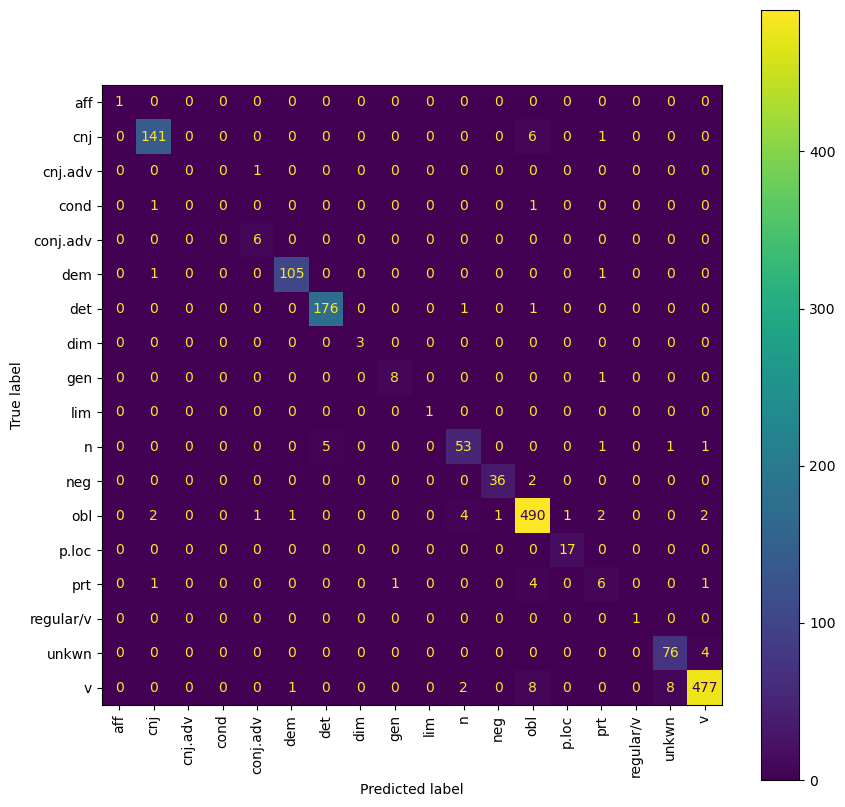

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,1,figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_test_flat, y_pred_flat, xticks_rotation='vertical', ax=ax)

#### Ejemplo de oración etiquetada

In [23]:
def sent_with_features_to_string(sent):
    return ' '.join(word_dict['word'] for word_dict in sent)

def print_tagged_sample(index, X, Y, Y_pred):
    print("Oración:", sent_with_features_to_string(X[index]))
    print("Predicción:", Y_pred[index])
    print("Correcto:", Y[index])

In [24]:
print_tagged_sample(0, X_test, y_test, y_pred)

Oración: pa hitsa dóndú ri̱ ngú
Predicción: ['obl', 'obl', 'v', 'det', 'obl']
Correcto: ['obl', 'neg', 'v', 'det', 'obl']


## Análisis
- ¿Qué diferencias encuentran entre trabajar con textos en español y en Otomí?

Hay muy pocos recursos del idioma Otomí, y aún menos del Otomí de Toluca, variante de la región San Andrés Cuexcontitlan; por lo que no encontré información acerca del funcionamiento de su morforlogía ni de su sintaxis. Así que para saber qué poner como parte de las features tuve que analizar la glosa proporcionada en el corpus. De esta forma de que muchas inflexiones se hacían antes del stem, así que decidí agregar los morfemas anteriores y posteriores al stem como features.

Las diferencias entre trabajar con textos en español y Otomí es que, como estoy familiarizada con el español, sé qué podría funcionar como features, y con el Otomí no sabía qué agregar. También, el corpus en español que utilizamos era más grande que el de Otomí, así que claramente se logró un mejor desempeño en el modelo.

- ¿Se obtuvieron buenos o malos resultados? ¿Porqué?

La accuracy lograda fue bastante buena (mayor a 90%), y aunque la precisión, el recall y F1-score no fueron tan buenos, no fueron malos (alrededor del 80%). Pienso que los resultados fueron muy soprendentes para la poca cantida de ejemplares con la que contábamos.